## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [4]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [5]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


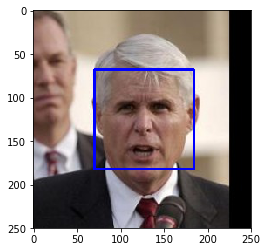

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
- 100
- 11

In [10]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

def calc_detector_accuracy(human_files, dog_files, detector):
    num_detected_in_human = 0
    num_detected_in_dog = 0

    for file in human_files:
        if detector(file):
            num_detected_in_human += 1
    
    for file in dog_files:
        if detector(file):
            num_detected_in_dog += 1   
    return num_detected_in_human, num_detected_in_dog

In [6]:
num_face_images_in_human, num_face_images_in_dog = calc_detector_accuracy(
                                                    human_files_short, dog_files_short, face_detector)

print("Number of human images in which faces was detected: ", num_face_images_in_human)
print("Number of dog images in which faces was detected: ", num_face_images_in_dog)

Number of human images in which faces was detected:  100
Number of dog images in which faces was detected:  11


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ This might not be very reasonable. Users might want to try out the app on photos which they have taken earlier, which may or may not have a clear face. There are multiple algorithms to detect humans from traditional HOG to Deep CNNs.
Once we detect a human, we can try to detect the face using either the given classifier or other algorithms, like MT-CNN.
(Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Neural Networks by K. Zhang and Z. Zhang and Z. Li and Y. Qiao). https://colab.research.google.com/drive/1UwvX6wZu2d_W6Fe-Oz0_P4BitP1b0K96
Gets 94% in the first 100 images. Since we are using Deep Learning, we can also train our model to detect partially occluded faces, similar to what W. Ouyang did in his paper on detecting occluded pedestrians. From the face dataset, we can put random occlusions and train the network.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

Number of faces Detected by MTCNN in human_files = 94

Number of faces Detected by MTCNN in dog_files = 0

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.
! pip3 install mtcnn

    100% |████████████████████████████████| 2.3MB 279kB/s eta 0:00:01    71% |███████████████████████         | 1.6MB 14.8MB/s eta 0:00:01
  Running setup.py bdist_wheel for mtcnn ... done
  Stored in directory: /root/.cache/pip/wheels/be/dd/12/bccde6b95f576af24256f6f1a2e4087eb8488405a6c107e13c
Successfully built mtcnn
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
from mtcnn.mtcnn import MTCNN
import cv2
detector = MTCNN()

In [8]:
def face_detector_mtcnn(img_path):
    img = cv2.imread(img_path)
    faces = detector.detect_faces(img)
    return len(faces) > 0

In [11]:
num_detected_in_human = 0
i = 1
for file in human_files_short:
    if face_detector_mtcnn(file):
        num_detected_in_human += 1
    if(i % 10 == 0):
        print(i, ") Processed file:", file, "      Total images with faces",
          num_detected_in_human)     
    i += 1
        

10 ) Processed file: /data/lfw/James_Wolfensohn/James_Wolfensohn_0002.jpg       Total images with faces 10
20 ) Processed file: /data/lfw/Natalie_Coughlin/Natalie_Coughlin_0006.jpg       Total images with faces 20
30 ) Processed file: /data/lfw/Alain_Ducasse/Alain_Ducasse_0001.jpg       Total images with faces 29
40 ) Processed file: /data/lfw/Randall_Tobias/Randall_Tobias_0001.jpg       Total images with faces 39
50 ) Processed file: /data/lfw/Laura_Bozzo/Laura_Bozzo_0001.jpg       Total images with faces 49
60 ) Processed file: /data/lfw/Brad_Johnson/Brad_Johnson_0001.jpg       Total images with faces 59
70 ) Processed file: /data/lfw/Luiz_Felipe_Scolari/Luiz_Felipe_Scolari_0002.jpg       Total images with faces 67
80 ) Processed file: /data/lfw/Jose_Maria_Aznar/Jose_Maria_Aznar_0019.jpg       Total images with faces 75
90 ) Processed file: /data/lfw/Lindsay_Davenport/Lindsay_Davenport_0018.jpg       Total images with faces 85
100 ) Processed file: /data/lfw/George_W_Bush/George_W_Bu

In [12]:
num_detected_in_dog = 0
i = 1
for file in dog_files_short:
    if face_detector_mtcnn(file):
        num_detected_in_dog += 1
    if(i % 10 == 0):
        print(i, ") Processed file:", file, "      Total images with faces",
          num_detected_in_dog)     
    i += 1

10 ) Processed file: /data/dog_images/train/081.Greyhound/Greyhound_05559.jpg       Total images with faces 0
20 ) Processed file: /data/dog_images/train/051.Chow_chow/Chow_chow_03650.jpg       Total images with faces 0
30 ) Processed file: /data/dog_images/train/106.Newfoundland/Newfoundland_06982.jpg       Total images with faces 0
40 ) Processed file: /data/dog_images/train/062.English_setter/English_setter_04407.jpg       Total images with faces 0
50 ) Processed file: /data/dog_images/train/110.Norwegian_lundehund/Norwegian_lundehund_07220.jpg       Total images with faces 0
60 ) Processed file: /data/dog_images/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03305.jpg       Total images with faces 0
70 ) Processed file: /data/dog_images/train/090.Italian_greyhound/Italian_greyhound_06130.jpg       Total images with faces 0
80 ) Processed file: /data/dog_images/train/106.Newfoundland/Newfoundland_07004.jpg       Total images with faces 0
90 ) Processed file: /

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [5]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 3s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [7]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [35]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    print(prediction)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
- 0
- 100

In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

num_dog_images_in_human, num_dog_images_in_dog = calc_detector_accuracy(
                                                    human_files_short, dog_files_short, dog_detector)

print("Number of human images in which dog was detected: ", num_dog_images_in_human)
print("Number of dog images in which dog was detected: ", num_dog_images_in_dog)

Number of human images in which dog was detected:  0
Number of dog images in which dog was detected:  100


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [9]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255


100%|██████████| 836/836 [00:08<00:00, 103.94it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__  Performance was bad on both train and validation set, which is a sign of high bias. So tried to include more layers and more parameters. This increased the performance, but after 30 epochs, there was over fitting.  All the experimentation after this is in available on https://colab.research.google.com/drive/1ZpRhI57g81qT8dSHy8sXSVH1eWhl0jUV. Also, used augmented data. Tried to regularize using Dropout layers. To speed up the training, used Batch Norm Layer. Then increased the number of layers(hence, the number of parameters) to finally get accuracy of 27%. Finally used some data augmentation to get accuracy of 35%. As mentioned in the previous review, I tried softmax instead of sigmoid activation and results are better., the best one being 38.7%.
My general observation is that softmax activation on the final layer gives a boost of 2%-5% and Data Augmentation can provide a boost of another 3%-4%

In [10]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
filter_size = (5, 5)

model.add(Conv2D(16, filter_size, activation="relu", padding="valid", input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, filter_size, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, filter_size, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation="softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 220, 220, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 106, 106, 32)      12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 49, 49, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 


In [12]:
from keras.callbacks import ModelCheckpoint  
### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 20

## Actually trained for 20 epochs in two sets of 10 epochs each
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_softmax.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=128, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 26s 4ms/step - loss: 4.8885 - acc: 0.0076 - val_loss: 4.8805 - val_acc: 0.0072
Epoch 2/20
6680/6680 [==============================] - 20s 3ms/step - loss: 4.8773 - acc: 0.0097 - val_loss: 4.8709 - val_acc: 0.0108
Epoch 3/20
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8636 - acc: 0.0130 - val_loss: 4.8433 - val_acc: 0.0132
Epoch 4/20
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8274 - acc: 0.0160 - val_loss: 4.7846 - val_acc: 0.0180
Epoch 5/20
6680/6680 [==============================] - 21s 3ms/step - loss: 4.7554 - acc: 0.0192 - val_loss: 4.7466 - val_acc: 0.0299
Epoch 6/20
6680/6680 [==============================] - 21s 3ms/step - loss: 4.7072 - acc: 0.0235 - val_loss: 4.7312 - val_acc: 0.0323
Epoch 7/20
6680/6680 [==============================] - 20s 3ms/step - loss: 4.6878 - acc: 0.0263 - val_loss: 4.6940 - val_acc: 0.0251
Epoch 8/

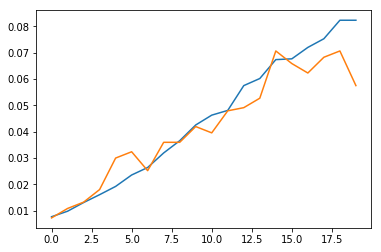

In [13]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 5]
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

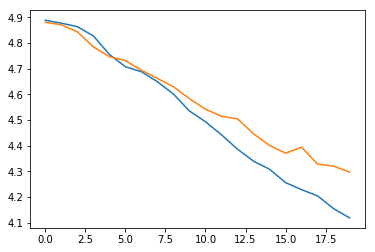

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [15]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy before loading best model: %.4f%%' % test_accuracy)

Test accuracy before loading best model: 7.4163%


### Load the Model with the Best Validation Loss

In [20]:
model.load_weights('saved_models/weights.best.from_scratch_softmax.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [21]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 7.4163%


### Trial with different architecture and layers to get better result ###

1 extra Layer with 128 units

In [22]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 5]

import numpy as np

filter_size = (5, 5)

def train_test(epochs = 1, name="1"):
    
    model = Sequential()

    model.add(Conv2D(16, filter_size, activation="relu", padding="valid", input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, filter_size, activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, filter_size, activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, filter_size, activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(133, activation="softmax"))

    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    from keras.callbacks import ModelCheckpoint  

    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_{}_softmax.hdf5'.format(name), 
                                   verbose=1, save_best_only=True)

    history = model.fit(train_tensors, train_targets, 
              validation_data=(valid_tensors, valid_targets),
              epochs=epochs, batch_size=256, callbacks=[checkpointer], verbose=1)
    
    predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
    test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
    print('Test accuracy before loding best: %.4f%%' % test_accuracy)
    
    model.load_weights('saved_models/weights.best.from_scratch_{}_softmax.hdf5'.format(name)) 
    
    predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
    test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
    print('Test accuracy before loding best: %.4f%%' % test_accuracy)
    
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    
    plt.show()
    
    return history

Train on 6680 samples, validate on 835 samples
Epoch 1/40
6680/6680 [==============================] - 22s 3ms/step - loss: 4.8811 - acc: 0.0088 - val_loss: 4.8605 - val_acc: 0.0072
Epoch 2/40
6680/6680 [==============================] - 22s 3ms/step - loss: 4.8365 - acc: 0.0124 - val_loss: 4.7917 - val_acc: 0.0192
Epoch 3/40
6680/6680 [==============================] - 22s 3ms/step - loss: 4.7396 - acc: 0.0259 - val_loss: 4.6957 - val_acc: 0.0228
Epoch 4/40
6680/6680 [==============================] - 22s 3ms/step - loss: 4.6497 - acc: 0.0259 - val_loss: 4.6097 - val_acc: 0.0228
Epoch 5/40
6680/6680 [==============================] - 22s 3ms/step - loss: 4.5337 - acc: 0.0338 - val_loss: 4.5974 - val_acc: 0.0359
Epoch 6/40
6680/6680 [==============================] - 22s 3ms/step - loss: 4.4772 - acc: 0.0397 - val_loss: 4.5063 - val_acc: 0.0431
Epoch 7/40
6680/6680 [==============================] - 22s 3ms/step - loss: 4.4284 - acc: 0.0431 - val_loss: 4.5097 - val_acc: 0.0407
Epoch 8/

Epoch 28/40
6680/6680 [==============================] - 22s 3ms/step - loss: 3.2203 - acc: 0.2196 - val_loss: 3.7669 - val_acc: 0.1353
Epoch 29/40
6680/6680 [==============================] - 22s 3ms/step - loss: 3.1793 - acc: 0.2244 - val_loss: 4.0906 - val_acc: 0.1246
Epoch 30/40
6680/6680 [==============================] - 22s 3ms/step - loss: 3.2091 - acc: 0.2171 - val_loss: 4.4104 - val_acc: 0.1198
Epoch 31/40
6680/6680 [==============================] - 22s 3ms/step - loss: 3.1821 - acc: 0.2253 - val_loss: 3.8311 - val_acc: 0.1365
Epoch 32/40
6680/6680 [==============================] - 22s 3ms/step - loss: 3.0276 - acc: 0.2542 - val_loss: 3.7988 - val_acc: 0.1461
Epoch 33/40
6680/6680 [==============================] - 22s 3ms/step - loss: 3.0049 - acc: 0.2609 - val_loss: 3.9095 - val_acc: 0.1305
Epoch 34/40
6680/6680 [==============================] - 22s 3ms/step - loss: 2.9731 - acc: 0.2576 - val_loss: 3.8365 - val_acc: 0.1533
Epoch 35/40
6680/6680 [=========================

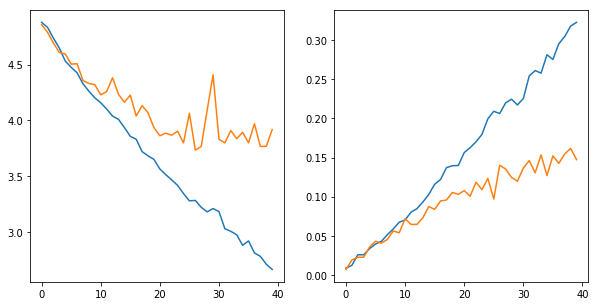

In [23]:
extended_hist = train_test(epochs=40)

There was one more trial with a simple architecture, Data Augmentation and softmax activation. Trained it on GPU but forgot to save the notebook before switching back to the normal env. So, that was basiaclly almost 2.5 hours of wasted GPU compute. Moved it to Google Colab(link above).
The Colab notebook also covers multiple other trials 

#### ---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [26]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [51]:
VGG16_model = Sequential()
# VGG16_model.add(Dense(128, activation='softmax', input_shape=train_VGG16.shape[1:]))
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_9 ( (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [52]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the Model

In [60]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

## Actually trained in twice, once with epochs=20, then with epochs=40
vgg_history_2 = VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=40, batch_size=64, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/40
6680/6680 [==============================] - 1s 136us/step - loss: 7.7964 - acc: 0.5163 - val_loss: 8.3965 - val_acc: 0.4323
Epoch 2/40
6680/6680 [==============================] - 1s 135us/step - loss: 7.7962 - acc: 0.5163 - val_loss: 8.4010 - val_acc: 0.4323
Epoch 3/40
6680/6680 [==============================] - 1s 134us/step - loss: 7.7962 - acc: 0.5163 - val_loss: 8.4019 - val_acc: 0.4335
Epoch 4/40
6680/6680 [==============================] - 1s 136us/step - loss: 7.7961 - acc: 0.5163 - val_loss: 8.4023 - val_acc: 0.4335
Epoch 5/40
6680/6680 [==============================] - 1s 133us/step - loss: 7.7961 - acc: 0.5163 - val_loss: 8.4028 - val_acc: 0.4347
Epoch 6/40
6680/6680 [==============================] - 1s 136us/step - loss: 7.7961 - acc: 0.5163 - val_loss: 8.4029 - val_acc: 0.4347
Epoch 7/40
6680/6680 [==============================] - 1s 135us/step - loss: 7.7961 - acc: 0.5163 - val_loss: 8.4025 - val_acc: 0.4347
E

6680/6680 [==============================] - 1s 136us/step - loss: 7.7125 - acc: 0.5165 - val_loss: 8.4214 - val_acc: 0.4347
Epoch 33/40
6680/6680 [==============================] - 1s 134us/step - loss: 7.7005 - acc: 0.5192 - val_loss: 8.4728 - val_acc: 0.4180
Epoch 34/40
6680/6680 [==============================] - 1s 134us/step - loss: 7.6995 - acc: 0.5195 - val_loss: 8.4080 - val_acc: 0.4240
Epoch 35/40
6680/6680 [==============================] - 1s 135us/step - loss: 7.6573 - acc: 0.5226 - val_loss: 8.4042 - val_acc: 0.4216
Epoch 36/40
6680/6680 [==============================] - 1s 135us/step - loss: 7.6168 - acc: 0.5222 - val_loss: 8.4079 - val_acc: 0.4216
Epoch 37/40
6680/6680 [==============================] - 1s 135us/step - loss: 7.5745 - acc: 0.5281 - val_loss: 8.3480 - val_acc: 0.4275
Epoch 38/40
6680/6680 [==============================] - 1s 136us/step - loss: 7.5686 - acc: 0.5295 - val_loss: 8.3396 - val_acc: 0.4299
Epoch 39/40
6680/6680 [==============================

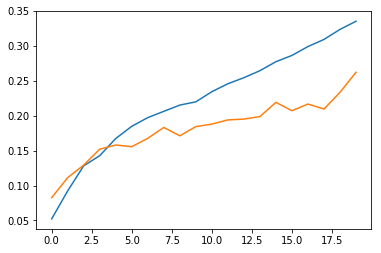

In [49]:
plt.plot(vgg_history.history['acc'])
plt.plot(vgg_history.history['val_acc'])
plt.show()

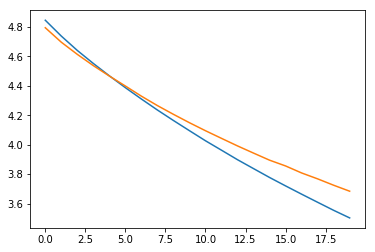

In [50]:
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.show()

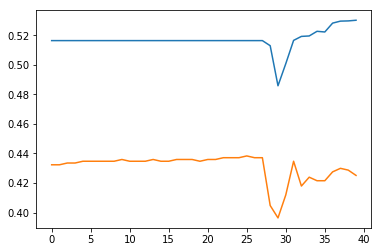

In [61]:
plt.plot(vgg_history_2.history['acc'])
plt.plot(vgg_history_2.history['val_acc'])
plt.show()

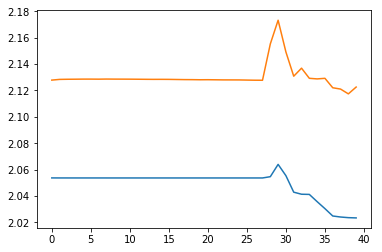

In [62]:
plt.plot(np.log(vgg_history_2.history['loss']))
plt.plot(np.log(vgg_history_2.history['val_loss']))
plt.show()

### Load the Model with the Best Validation Loss

In [64]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [65]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 43.8995%


### Predict Dog Breed with the Model

In [66]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras.  These are already in the workspace, at /data/bottleneck_features.  If you wish to download them on a different machine, they can be found at:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  

The above architectures are downloaded and stored for you in the `/data/bottleneck_features/` folder.

This means the following will be in the `/data/bottleneck_features/` folder:

`DogVGG19Data.npz`
`DogResnet50Data.npz`
`DogInceptionV3Data.npz`
`DogXceptionData.npz`



### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('/data/bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [1]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
import numpy as np
bottleneck_features = np.load('/data/bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  For feature exraction, tried all the given options, the Xception net was working better than other, so chose that. For classifier, tried a few architectures, most had issues with overfitting, so here I have tried a simple architecture. 

In [19]:
### TODO: Define your architecture.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

Xception2 = Sequential()

Xception2.add(MaxPooling2D(pool_size=2, input_shape=train_Xception.shape[1:]))
Xception2.add(GlobalAveragePooling2D())
Xception2.add(Dense(133, activation='softmax'))
Xception2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 2048)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [20]:
### TODO: Compile the model.
Xception2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [21]:
### TODO: Train the model.
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception1.hdf5', 
                               verbose=1, save_best_only=True)

Xception_history_2 = Xception2.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=40, batch_size=128, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/40
6680/6680 [==============================] - 17s 3ms/step - loss: 1.5596 - acc: 0.6430 - val_loss: 0.5698 - val_acc: 0.8323
Epoch 2/40
6680/6680 [==============================] - 14s 2ms/step - loss: 0.4153 - acc: 0.8744 - val_loss: 0.5134 - val_acc: 0.8407
Epoch 3/40
6680/6680 [==============================] - 11s 2ms/step - loss: 0.2958 - acc: 0.9136 - val_loss: 0.4875 - val_acc: 0.8359
Epoch 4/40
6680/6680 [==============================] - 7s 1ms/step - loss: 0.2216 - acc: 0.9391 - val_loss: 0.4782 - val_acc: 0.8515
Epoch 5/40
6680/6680 [==============================] - 3s 449us/step - loss: 0.1726 - acc: 0.9575 - val_loss: 0.4623 - val_acc: 0.8491
Epoch 6/40
6680/6680 [==============================] - 3s 437us/step - loss: 0.1376 - acc: 0.9683 - val_loss: 0.4731 - val_acc: 0.8539
Epoch 7/40
6680/6680 [==============================] - 3s 447us/step - loss: 0.1146 - acc: 0.9781 - val_loss: 0.4607 - val_acc: 0.8515
Epoch 

Epoch 31/40
6680/6680 [==============================] - 3s 445us/step - loss: 0.0133 - acc: 0.9987 - val_loss: 0.5073 - val_acc: 0.8515
Epoch 32/40
6680/6680 [==============================] - 3s 424us/step - loss: 0.0127 - acc: 0.9984 - val_loss: 0.5127 - val_acc: 0.8479
Epoch 33/40
6680/6680 [==============================] - 3s 428us/step - loss: 0.0117 - acc: 0.9988 - val_loss: 0.5031 - val_acc: 0.8515
Epoch 34/40
6680/6680 [==============================] - 3s 435us/step - loss: 0.0128 - acc: 0.9988 - val_loss: 0.5052 - val_acc: 0.8551
Epoch 35/40
6680/6680 [==============================] - 3s 423us/step - loss: 0.0125 - acc: 0.9987 - val_loss: 0.5052 - val_acc: 0.8575
Epoch 36/40
6680/6680 [==============================] - 3s 441us/step - loss: 0.0104 - acc: 0.9993 - val_loss: 0.5121 - val_acc: 0.8527
Epoch 37/40
6680/6680 [==============================] - 3s 444us/step - loss: 0.0100 - acc: 0.9990 - val_loss: 0.5099 - val_acc: 0.8515
Epoch 38/40
6680/6680 [==================

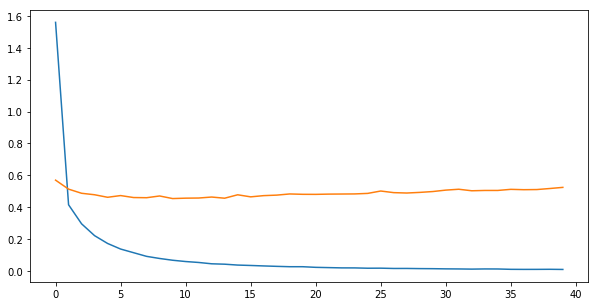

In [22]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 5]

plt.plot(Xception_history_2.history['loss'])
plt.plot(Xception_history_2.history['val_loss'])
plt.show()

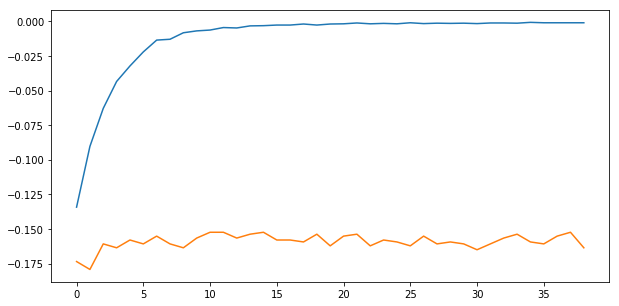

In [28]:
plt.plot(Xception_history_2.history['acc'][1:])
plt.plot(Xception_history_2.history['val_acc'][1:])
plt.show()

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [25]:
### TODO: Load the model weights with the best validation loss.
Xception.load_weights('saved_models/weights.best.Xception1.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [26]:
### TODO: Calculate classification accuracy on the test dataset.
Xception_predictions = [np.argmax(Xception.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 86.2440%


### Experiment with other available feature extractors ###
Also tried two different architectures of the final classifer.
One with max pooling, another one without.

In [17]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 5]

import numpy as np

def train_test_model(network, arch=1):
    bottleneck_features = np.load('/data/bottleneck_features/Dog{}Data.npz'.format(network))
    train = bottleneck_features['train']
    valid = bottleneck_features['valid']
    test = bottleneck_features['test']

    model = Sequential()

    if arch == 1: 
        model.add(GlobalAveragePooling2D(input_shape=train.shape[1:]))
    else:
        model.add(MaxPooling2D(pool_size=2, input_shape=train.shape[1:]))
        model.add(GlobalAveragePooling2D())
    
    model.add(Dense(133, activation='softmax'))
    model.summary()

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.{}.hdf5'.format(network), 
                                   verbose=1, save_best_only=True)

    model_history = model.fit(train, train_targets, 
              validation_data=(valid, valid_targets),
              epochs=40, batch_size=128, callbacks=[checkpointer], verbose=1)

    model_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test]
    test_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(test_targets, axis=1))/len(model_predictions)
    print('Test accuracy: %.4f%%' % test_accuracy)
    
    model.load_weights('saved_models/weights.best.{}.hdf5'.format(network)) 
    
    model_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test]
    test_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(test_targets, axis=1))/len(model_predictions)
    print('Test accuracy after loading best weights: %.4f%%' % test_accuracy)
    
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    
    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['acc'])
    plt.plot(model_history.history['val_acc'])
    
    plt.show()
    
    return model_history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________
Train on 6680 samples, validate on 835 samples
Epoch 1/40
6680/6680 [==============================] - 2s 225us/step - loss: 2.6411 - acc: 0.4383 - val_loss: 1.2196 - val_acc: 0.6958
Epoch 2/40
6680/6680 [==============================] - 1s 164us/step - loss: 0.7070 - acc: 0.8424 - val_loss: 0.8474 - val_acc: 0.7725
Epoch 3/40
6680/6680 [==============================] - 1s 163us/step - loss: 0.4177 - acc: 0.9150 - val_loss: 0.7111 - val_acc: 0.7904
Epoch 4/40
6680/6680 [==============================] - 1s 161us/step - loss:

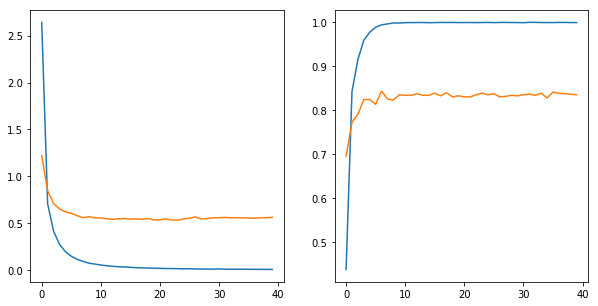

In [44]:
Resnet50_history = train_test_model("Resnet50")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________
Train on 6680 samples, validate on 835 samples
Epoch 1/40
6680/6680 [==============================] - 2s 333us/step - loss: 1.7037 - acc: 0.6235 - val_loss: 0.6349 - val_acc: 0.8120
Epoch 2/40
6680/6680 [==============================] - 2s 253us/step - loss: 0.4597 - acc: 0.8629 - val_loss: 0.5447 - val_acc: 0.8467
Epoch 3/40
6680/6680 [==============================] - 2s 250us/step - loss: 0.3264 - acc: 0.9052 - val_loss: 0.5587 - val_acc: 0.8240
Epoch 4/40
6680/6680 [==============================] - 2s 251us/step - loss:

6680/6680 [==============================] - 2s 259us/step - loss: 0.0153 - acc: 0.9988 - val_loss: 0.5517 - val_acc: 0.8635
Epoch 30/40
6680/6680 [==============================] - 2s 252us/step - loss: 0.0137 - acc: 0.9987 - val_loss: 0.5577 - val_acc: 0.8671
Epoch 31/40
6680/6680 [==============================] - 2s 249us/step - loss: 0.0131 - acc: 0.9985 - val_loss: 0.5503 - val_acc: 0.8611
Epoch 32/40
6680/6680 [==============================] - 2s 248us/step - loss: 0.0122 - acc: 0.9988 - val_loss: 0.5523 - val_acc: 0.8635
Epoch 33/40
6680/6680 [==============================] - 2s 251us/step - loss: 0.0134 - acc: 0.9985 - val_loss: 0.5492 - val_acc: 0.8695
Epoch 34/40
6680/6680 [==============================] - 2s 248us/step - loss: 0.0122 - acc: 0.9984 - val_loss: 0.5604 - val_acc: 0.8611
Epoch 35/40
6680/6680 [==============================] - 2s 247us/step - loss: 0.0117 - acc: 0.9988 - val_loss: 0.5667 - val_acc: 0.8623
Epoch 36/40
6680/6680 [==============================

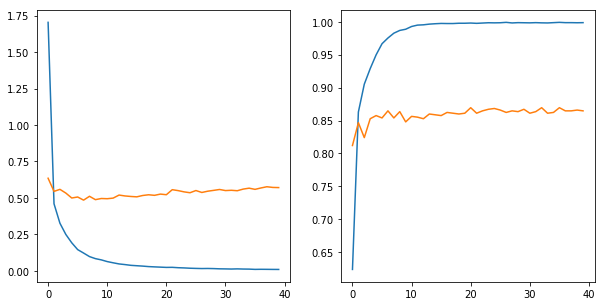

In [45]:
inception_history = train_test_model("InceptionV3")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 2048)        0         
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________
Train on 6680 samples, validate on 835 samples
Epoch 1/40
6680/6680 [==============================] - 3s 431us/step - loss: 1.8023 - acc: 0.5991 - val_loss: 0.7344 - val_acc: 0.7856
Epoch 2/40
6680/6680 [==============================] - 2s 279us/step - loss: 0.4855 - acc: 0.8493 - val_loss: 0.6894 - val_acc: 0.8096
Epoch 3/40
6680/6680 [==============================] - 2s 280us/step - loss: 0.3

Epoch 29/40
6680/6680 [==============================] - 2s 283us/step - loss: 0.0118 - acc: 0.9982 - val_loss: 0.6674 - val_acc: 0.8575
Epoch 30/40
6680/6680 [==============================] - 2s 306us/step - loss: 0.0126 - acc: 0.9984 - val_loss: 0.6815 - val_acc: 0.8599
Epoch 31/40
6680/6680 [==============================] - 2s 289us/step - loss: 0.0104 - acc: 0.9987 - val_loss: 0.6847 - val_acc: 0.8551
Epoch 32/40
6680/6680 [==============================] - 2s 290us/step - loss: 0.0091 - acc: 0.9988 - val_loss: 0.6675 - val_acc: 0.8575
Epoch 33/40
6680/6680 [==============================] - 2s 280us/step - loss: 0.0124 - acc: 0.9985 - val_loss: 0.6878 - val_acc: 0.8575
Epoch 34/40
6680/6680 [==============================] - 2s 289us/step - loss: 0.0089 - acc: 0.9988 - val_loss: 0.6991 - val_acc: 0.8551
Epoch 35/40
6680/6680 [==============================] - 2s 283us/step - loss: 0.0107 - acc: 0.9984 - val_loss: 0.6709 - val_acc: 0.8587
Epoch 36/40
6680/6680 [==================

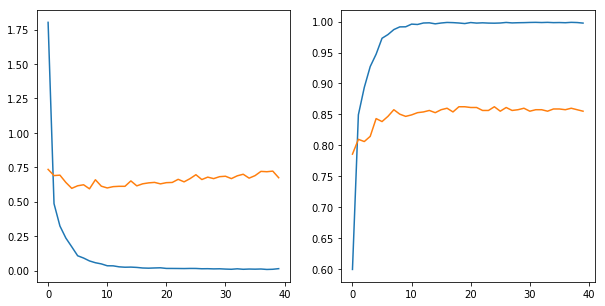

In [50]:
inception_history_1 = train_test_model("InceptionV3", arch=2)

As suggested in the previous review, will try to fix the problem of overfitting using dropout and batch norm

In [19]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 5]

import numpy as np

def train_test_regularized_model(network):
    bottleneck_features = np.load('/data/bottleneck_features/Dog{}Data.npz'.format(network))
    train = bottleneck_features['train']
    valid = bottleneck_features['valid']
    test = bottleneck_features['test']

    model = Sequential()

    model.add(GlobalAveragePooling2D(input_shape=train.shape[1:]))
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(133, activation='softmax'))
    model.summary()

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.{}.hdf5'.format(network), 
                                   verbose=1, save_best_only=True)

    model_history = model.fit(train, train_targets, 
              validation_data=(valid, valid_targets),
              epochs=40, batch_size=128, callbacks=[checkpointer], verbose=1)

    model_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test]
    test_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(test_targets, axis=1))/len(model_predictions)
    print('Test accuracy: %.4f%%' % test_accuracy)
    
    model.load_weights('saved_models/weights.best.{}.hdf5'.format(network)) 
    
    model_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test]
    test_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(test_targets, axis=1))/len(model_predictions)
    print('Test accuracy after loading best weights: %.4f%%' % test_accuracy)
    
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    
    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['acc'])
    plt.plot(model_history.history['val_acc'])
    
    plt.show()
    
    return model_history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_9 (Dense)              (None, 133)               34181     
Total params: 1,215,621
Trainable params: 1,215,109
Non-trainable params: 512
________________________________________________________________

Epoch 27/40
6680/6680 [==============================] - 6s 885us/step - loss: 0.0942 - acc: 0.9713 - val_loss: 0.6003 - val_acc: 0.8395
Epoch 28/40
6680/6680 [==============================] - 6s 898us/step - loss: 0.0783 - acc: 0.9763 - val_loss: 0.6401 - val_acc: 0.8431
Epoch 29/40
6680/6680 [==============================] - 6s 910us/step - loss: 0.0859 - acc: 0.9723 - val_loss: 0.5643 - val_acc: 0.8587
Epoch 30/40
6680/6680 [==============================] - 6s 892us/step - loss: 0.0994 - acc: 0.9699 - val_loss: 0.6199 - val_acc: 0.8551
Epoch 31/40
6680/6680 [==============================] - 6s 894us/step - loss: 0.0982 - acc: 0.9644 - val_loss: 0.6621 - val_acc: 0.8467
Epoch 32/40
6680/6680 [==============================] - 6s 890us/step - loss: 0.0725 - acc: 0.9769 - val_loss: 0.6416 - val_acc: 0.8431
Epoch 33/40
6680/6680 [==============================] - 6s 887us/step - loss: 0.0738 - acc: 0.9765 - val_loss: 0.6534 - val_acc: 0.8455
Epoch 34/40
6680/6680 [==================

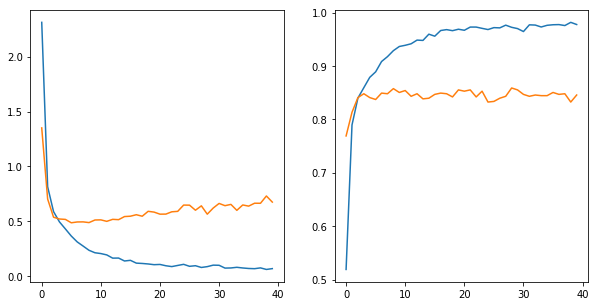

In [20]:
Xception_history_regularized = train_test_regularized_model('Xception')

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [47]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input, decode_predictions
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing import image                  

from tqdm import tqdm

import numpy as np

Xception_model = Xception(include_top=False, weights='imagenet')

model = Sequential()

model.add(MaxPooling2D(pool_size=2, input_shape=(10, 10, 2048)))
model.add(GlobalAveragePooling2D(input_shape=(7, 7, 2048)))
model.add(Dense(133, activation='softmax'))
model.summary()
model.load_weights('saved_models/weights.best.Xception1.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 2048)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [48]:
def path_to_tensor(img_path, target_size = (224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def Xception_bottleneck(img_path):
    img = preprocess_input(path_to_tensor(img_path, target_size=(299,299)))
    return Xception_model.predict(img)
    
def predict_breed(img_path):
    features = Xception_bottleneck(img_path)
    probs = model.predict(features)
    idx = np.argmax(probs)
    return dog_names[idx], probs[0][idx]

In [28]:
predict_breed('./images/Brittany_02625.jpg')

36


('in/037.Brittany', 0.45941237)

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [70]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

import cv2                
from glob import glob
import matplotlib.pyplot as plt                        
%matplotlib inline    

dog_names = [item[27:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

def detect_entity(img_path):
    entity = None
    breed, prob = predict_breed(img_path)
    if(prob > 0.15):
        entity = "dog"
    elif(face_detector(img_path)):
        entity = "human"
    
    return entity, breed, prob

In [87]:
img_path = './images/Brittany_02625.jpg'

def app(img_path):
    entity, breed, prob = detect_entity(img_path)

    if entity:
        print("Hello ", entity, "!")
        if entity == "human":
            print("You look like a...")
        print(breed, " prob:", prob)
    else:
        print("Error!")
    
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__  The classification of dogs is better than expected considering it was trained for fairly short amount of time. The dog breed it predicts is close to the actual breed. The model, however, sometimes predicts a cat to be a dog breed albiet with a low probability. This may be due to the similar body structure and the similar color of the fur. The model, also, performs poorly when it has to find a dog resembling the person. 
For the classifier network the major challenge here seems to be overfitting. We could try training more of the network rather than just using it as a feature extractor. AS suggested we can also try adding more layers and dropout and batch norm to regularize the network. I haven't been able to implement this correctly above. It's still overfitting. Another suggested method could be data augmentation, but then we would loose the advantage of just using the already extracted features and it would be computationally very expensive.
And specific to my algo, the threshold for dog detection is set to probability of 0.15 or above. This is more or less heurestic. We can use something like AUC-ROC curve to determine an optimum threshold.

Hello  dog !
American_eskimo_dog  prob: 0.792456


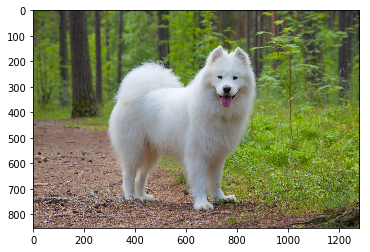

In [88]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
app('./test_images/dog1.jpg')

Hello  dog !
Alaskan_malamute  prob: 0.450345


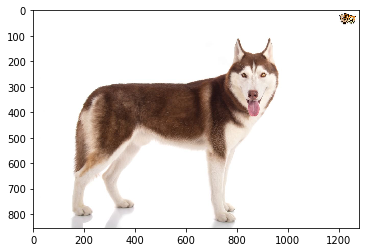

In [89]:
app('./test_images/dog2.jpg')

Hello  human !
You look like a...
Dachshund  prob: 0.0496742


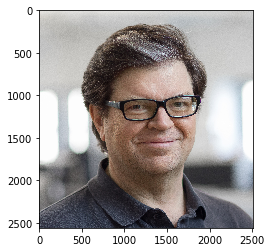

In [90]:
app('./test_images/person1.jpg')

Hello  human !
You look like a...
German_shepherd_dog  prob: 0.0331423


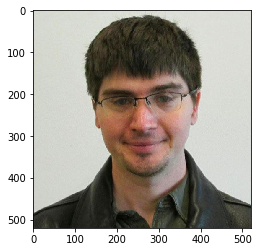

In [91]:
app('./test_images/person2.jpg')

Hello  human !
You look like a...
Dachshund  prob: 0.0439583


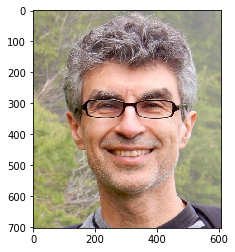

In [92]:
app('./test_images/person3.jpg')

Hello  human !
You look like a...
Dachshund  prob: 0.0680703


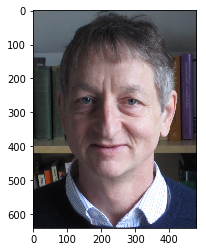

In [93]:
app('./test_images/person4.jpg')

Hello  dog !
Nova_scotia_duck_tolling_retriever  prob: 0.160344


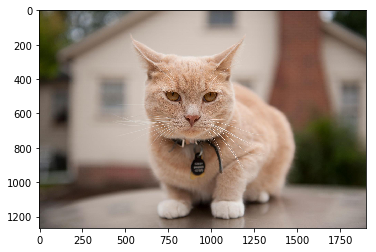

In [94]:
app('./test_images/cat1.jpg')

Error!


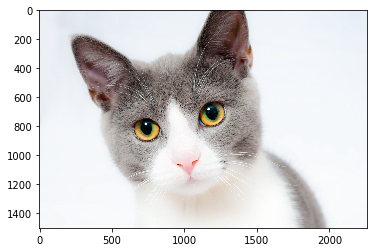

In [95]:
app('./test_images/cat2.jpeg')

Error!


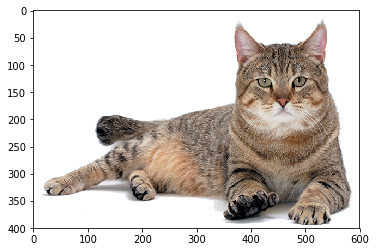

In [96]:
app('./test_images/cat3.jpg')

# Please download your notebook to submit

In order to submit, please do the following:
1.  Download an HTML version of the notebook to your computer using 'File: Download as...'
2.  Click on the orange Jupyter circle on the top left of the workspace.
3.  Navigate into the dog-project folder to ensure that you are using the provided dog_images, lfw, and bottleneck_features folders; this means that those folders will *not* appear in the dog-project folder.  If they do appear because you downloaded them, delete them.
4.  While in the dog-project folder, upload the HTML version of this notebook you just downloaded.  The upload button is on the top right.
5.  Navigate back to the home folder by clicking on the two dots next to the folder icon, and then open up a terminal under the 'new' tab on the top right
6.  Zip the dog-project folder with the following command in the terminal:
 `zip -r dog-project.zip dog-project`
7.  Download the zip file by clicking on the square next to it and selecting 'download'.  This will be the zip file you turn in on the next node after this workspace!